In [825]:
import numpy as np
import scipy
from scipy import special
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.special import expit


class BaseSmoothOracle:
    """
    Базовый класс для реализации оракулов.
    """
    def func(self, w):
        """
        Вычислить значение функции в точке w.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        """
        Вычислить значение градиента функции в точке w.
        """
        raise NotImplementedError('Grad oracle is not implemented.')

        
class BinaryLogistic(BaseSmoothOracle):
    """
    Оракул для задачи двухклассовой логистической регрессии.
    
    Оракул должен поддерживать l2 регуляризацию.
    """
    
    def __init__(self, l2_coef):
        """
        Задание параметров оракула.
        
        l2_coef - коэффициент l2 регуляризации
        """
        self.l2_coef = l2_coef
        pass
     
    def func(self, X, y, w):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w - одномерный numpy array
        """
        m = y * X.dot(w)
        try:
            return np.logaddexp(0, -m).mean() + self.l2_coef * (w[1:] ** 2).sum() / 2
        except:
            return super().func(w)
        
    def grad(self, X, y, w):
        """
        Вычислить градиент функционала в точке w на выборке X с ответами y.
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w - одномерный numpy array
        """
        m = y * X.dot(w)
        if isinstance(X, sparse.csr_matrix):
            return -np.array(X.multiply((expit(-m) * y)[:, np.newaxis]).mean(axis=0)).ravel() \
                   + self.l2_coef * np.append(0, w[1:])
        if isinstance(X, np.ndarray):
            return -((expit(-m) * y)[:, np.newaxis] * X).mean(axis=0) + self.l2_coef * np.append(0, w[1:])
        return super().grad(w)

In [826]:
import time
import scipy
from scipy import special
import numpy as np
from scipy import sparse
from scipy.sparse import csr_matrix


class GDClassifier:
    """
    Реализация метода градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """
    
    def __init__(self, loss_function, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, **kwargs):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора. 
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
                
        step_alpha - float, параметр выбора шага из текста задания
        
        step_beta- float, параметр выбора шага из текста задания
        
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию.
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход 
        
        max_iter - максимальное число итераций     
        
        **kwargs - аргументы, необходимые для инициализации   
        """
        self.alpha = step_alpha
        self.beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.loss_function = loss_function
        self.oracle = BinaryLogistic(**kwargs)
            
    def fit(self, X, y, w_0=None, trace=False, X_test=None, y_test=None):
        """
        Обучение метода по выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w_0 - начальное приближение в методе
        
        trace - переменная типа bool
      
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию 
        о поведении метода. Длина словаря history = количество итераций + 1 (начальное приближение)
        
        history['time']: list of floats, содержит интервалы времени между двумя итерациями метода
        history['func']: list of floats, содержит значения функции на каждой итерации
        (0 для самой первой точки)
        """
        def accuracy(y, z):
            return np.equal(y, z).astype(int).mean()
        self.w = np.zeros(X.shape[1])

        if w_0 is not None:
            self.w = w_0
        history = {}
        history['time'] = []
        history['func'] = [self.oracle.func(X, y, self.w)]
        if X_test is not None:
            history['accuracy'] = [accuracy(np.sign(X_test.dot(self.w)), y_test)]
        begin = time.time()
        for t in range(1, self.max_iter + 1):
            grad = self.oracle.grad(X, y, self.w)
            self.w -= (self.alpha / (t ** self.beta)) * grad
            end = time.time()
            if X_test is not None:
                history['accuracy'].append(accuracy(np.sign(X_test.dot(self.w)), y_test))
            history['time'].append(end - begin)
            history['func'].append(self.oracle.func(X, y, self.w))
            if abs(history['func'][-1] - history['func'][-2]) < self.tolerance:
                break
            begin = time.time()
        if trace is True:
            return history
            
        
        
    def predict(self, X):
        """
        Получение меток ответов на выборке X
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        return: одномерный numpy array с предсказаниями
        """
        return np.sign(X.dot(self.w))

    def predict_proba(self, X):
        """
        Получение вероятностей принадлежности X к классу k
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        return: двумерной numpy array, [i, k] значение соответветствует вероятности
        принадлежности i-го объекта к классу k 
        """
        proba = scipy.special.expit(X.dot(self.w))[:, np.newaxis]
        return np.hstack((proba, 1 - proba))
        
    def get_objective(self, X, y):
        """
        Получение значения целевой функции на выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        
        return: float
        """
        return self.oracle.func(X, y, self.w)
        
    def get_gradient(self, X, y):
        """
        Получение значения градиента функции на выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        
        return: numpy array, размерность зависит от задачи
        """
        return self.oracle.grad(X, y, self.w)
    
    def get_weights(self):
        """
        Получение значения весов функционала
        """    
        return self.w


class SGDClassifier(GDClassifier):
    """
    Реализация метода стохастического градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """
    
    def __init__(self, loss_function, batch_size, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, random_seed=153, **kwargs):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора. 
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
        
        batch_size - размер подвыборки, по которой считается градиент
        
        step_alpha - float, параметр выбора шага из текста задания
        
        step_beta- float, параметр выбора шага из текста задания
        
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход 
        
        
        max_iter - максимальное число итераций (эпох)
        
        random_seed - в начале метода fit необходимо вызвать np.random.seed(random_seed).
        Этот параметр нужен для воспроизводимости результатов на разных машинах.
        
        **kwargs - аргументы, необходимые для инициализации
        """
        self.alpha = step_alpha
        self.beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.loss_function = loss_function
        self.batch = batch_size
        self.seed = random_seed
        self.oracle = BinaryLogistic(**kwargs)
        
    def fit(self, X, y, w_0=None, trace=False, log_freq=1, X_test=None, y_test=None):
        """
        Обучение метода по выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
                
        w_0 - начальное приближение в методе
        
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию 
        о поведении метода. Если обновлять history после каждой итерации, метод перестанет 
        превосходить в скорости метод GD. Поэтому, необходимо обновлять историю метода лишь
        после некоторого числа обработанных объектов в зависимости от приближённого номера эпохи.
        Приближённый номер эпохи:
            {количество объектов, обработанных методом SGD} / {количество объектов в выборке}
        
        log_freq - float от 0 до 1, параметр, отвечающий за частоту обновления. 
        Обновление должно проиходить каждый раз, когда разница между двумя значениями приближённого номера эпохи
        будет превосходить log_freq.
        
        history['epoch_num']: list of floats, в каждом элементе списка будет записан приближённый номер эпохи:
        history['time']: list of floats, содержит интервалы времени между двумя соседними замерами
        history['func']: list of floats, содержит значения функции после текущего приближённого номера эпохи
        history['weights_diff']: list of floats, содержит квадрат нормы разности векторов весов с соседних замеров
        (0 для самой первой точки)
        """
        def accuracy(y, z):
            return np.equal(y, z).astype(int).mean()
        np.random.seed(self.seed)
        self.w = np.zeros(X.shape[1])
        if w_0 is not None:
            self.w = w_0
        history = {}
        history['time'] = []
        func_prev = self.oracle.func(X, y, self.w)
        history['func'] = [func_prev]
        history['epoch_num'] = [0]
        history['weights_diff'] = [0]
        history['w'] = [self.w]
        if X_test is not None:
            history['accuracy'] = [accuracy(np.sign(X_test.dot(self.w)), y_test)]
        begin = time.time()
        for t in range(1, self.max_iter + 1):
            i = (t - 1) % ((X.shape[0] - 1) // self.batch + 1)
            if i == 0:
                batch = np.random.randint(0, X.shape[0], size=X.shape[0])
            ind = batch[i : i + self.batch]
            self.w -= self.alpha / (t ** self.beta) * self.oracle.grad(X[ind], y[ind], self.w)
            func_now = self.oracle.func(X, y, self.w)
            if t * self.batch / X.shape[0]  - history['epoch_num'][-1] > log_freq:
                history['epoch_num'].append(t * self.batch / X.shape[0])
                end = time.time()
                history['time'].append(end - begin)
                begin = end
                history['func'].append(func_now)
                history['weights_diff'].append(np.linalg.norm(self.w - history['w'][-1]))
                history['w'].append([self.w])
                if X_test is not None:
                    history['accuracy'].append(accuracy(np.sign(X_test.dot(self.w)), y_test))
            if abs(func_now - func_prev) < self.tolerance:
                break
            func_prev = func_now
        if trace is True:
            return history
    def predict(self, X):
        return np.sign(X.dot(self.w))

In [1127]:
def grad_finite_diff(function, w, eps=1e-8):
    """
    Возвращает численное значение градиента, подсчитанное по следующией формуле:
        result_i := (f(w + eps * e_i) - f(w)) / eps,
        где e_i - следующий вектор:
        e_i = (0, 0, ..., 0, 1, 0, ..., 0)
                          >> i <<
    """
#Случай векторизованной функции
#    E = np.zeros((w.size, w.size))
#    np.fill_diagonal(E, eps)
#    return (function(E + w[:, np.newaxis]) - function(w)[:, np.newaxis]) / eps
# Иначе
    result = np.empty_like(w).astype(float)
    E = np.identity(w.shape[0])
    for i in range(result.shape[0]):
        result[i] = (function(w + eps * E[i]) - function(w)) / eps
    return result
    

In [1130]:
def f(w):
    return np.sin(w)[0]
grad_finite_diff(f, np.array([2]))

array([-0.41614684])

In [1131]:
np.cos(np.array([2]))

array([-0.41614684])

In [1184]:
import pandas as pd
import re

In [1185]:
data = pd.read_csv('toxic_train.csv')
test = pd.read_csv('toxic_test.csv')

In [1186]:
del data["Unnamed: 0"]
del test["Unnamed: 0"]

In [1187]:
data['comment_text'] = data['comment_text'].str.lower()
test['comment_text'] = test['comment_text'].str.lower()
data['comment_text'] = data['comment_text'].str.replace(r'[^a-zа-яё0-9]', ' ')
test['comment_text'] = test['comment_text'].str.replace(r'[^a-zа-яё0-9]', ' ')

In [1188]:
data['comment_text'] = data['comment_text'].apply(lambda x: ' '.join(x.split()))
test['comment_text'] = test['comment_text'].apply(lambda x: ' '.join(x.split()))

In [1189]:
data['answer'] = data['is_toxic'].replace(False, -1).astype(np.int8)
test['answer'] = test['is_toxic'].replace(False, -1).astype(np.int8)

In [1190]:
import sklearn

Возьмем 2/3 для обучения и будем тестировать на оставшейся 1/3

In [1191]:
train_data, test_data, y_train, y_test = sklearn.model_selection.train_test_split(data['comment_text'], 
                                                          data['answer'], test_size=0.33, random_state=42)

Возьмем слова, встречающиеся больше чем в одном комментарии

In [732]:
1 / train_data.shape[0]

2.8669724770642203e-05

In [835]:
from sklearn.feature_extraction.text import CountVectorizer

In [836]:
bag_of_words = CountVectorizer(min_df=3e-5)
bag_of_words.fit(train_data.values)
train_csr = bag_of_words.transform(train_data.values)
test_csr = bag_of_words.transform(test_data.values)
real_test_csr =  bag_of_words.transform(test['comment_text'].values)


train_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((train_csr.shape[0], 1)), dtype = int), train_csr)))
test_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((test_csr.shape[0], 1)), dtype = int), test_csr)))
real_test_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((real_test_csr.shape[0], 1)), \
                                                     dtype = int), real_test_csr )))
print('Number of words:', train_csr.shape[1])

Number of words: 29826


In [745]:
sgd = SGDClassifier('binary_logistic', step_alpha=1, step_beta=0, tolerance=1e-9, max_iter=4000, l2_coef=5e-07, \
                    batch_size=1000)
hist = sgd.fit(train_csr, y_train.values, trace=True, X_test=test_csr , \
              y_test=y_test.values)

In [746]:
np.equal(y_test.values, sgd.predict(test_csr).astype(int)).astype(int).mean()

0.9089110063442174

In [737]:
gd = GDClassifier('binary_logistic', step_alpha=1, step_beta=0, tolerance=1e-6, max_iter=2000, l2_coef=5e-04)
hist = gd.fit(train_csr, y_train.values, trace=True, X_test=test_csr , \
              y_test=y_test.values)

In [738]:
np.equal(y_test.values, gd.predict(test_csr).astype(int)).astype(int).mean()

0.892963156975729

In [618]:
def get_params(tol, it, l2):
    gd = GDClassifier('binary_logistic', step_alpha=1, step_beta=0, tolerance=tol, max_iter=it, l2_coef=l2)
    hist = gd.fit(train_csr, y_train.values, trace=True, X_test=test_csr , \
                  y_test=y_test.values)
    return len(hist['func']) < it, np.equal(y_test.values,\
                                            gd.predict(test_csr).astype(int)).astype(int).mean() 
iters = [1500, 2000]
tols = [1e-5, 5e-6]
coefs = [5e-04, 1e-05]
params = {}
for it in iters:
    for tol in tols:
        for l2 in coefs:
            params[(tol, it, l2)] = get_params(tol, it, l2)

In [619]:
params

{(1e-05, 1500, 0.0005): (True, 0.8878994237820849),
 (1e-05, 1500, 1e-05): (True, 0.8799254990978407),
 (5e-06, 1500, 0.0005): (False, 0.8912752459111809),
 (5e-06, 1500, 1e-05): (True, 0.8799837029276526),
 (1e-05, 2000, 0.0005): (True, 0.8878994237820849),
 (1e-05, 2000, 1e-05): (True, 0.8799254990978407),
 (5e-06, 2000, 0.0005): (False, 0.892963156975729),
 (5e-06, 2000, 1e-05): (True, 0.8799837029276526)}

{(1e-05, 1500, 0.0005): (True, 0.8878994237820849),
 (1e-05, 1500, 1e-05): (True, 0.8799254990978407),
 (5e-06, 1500, 0.0005): (False, 0.8912752459111809),
 (5e-06, 1500, 1e-05): (True, 0.8799837029276526),
 (1e-05, 2000, 0.0005): (True, 0.8878994237820849),
 (1e-05, 2000, 1e-05): (True, 0.8799254990978407),
 (5e-06, 2000, 0.0005): (False, 0.892963156975729),
 (5e-06, 2000, 1e-05): (True, 0.8799837029276526)}

tolerance = 8e-06, max_iter = 1500, l2 = 5e-04

In [622]:
def get_hist_gd(alpha, beta, w_0):
    gd = GDClassifier('binary_logistic', step_alpha=alpha, step_beta=beta, tolerance=8e-06, 
                      max_iter=1500, l2_coef=5e-04)
    return gd.fit(train_csr, y_train.values, trace=True, w_0=w_0, X_test=test_csr,
                  y_test=y_test.values)

In [623]:
import matplotlib.pyplot as plt

In [624]:
alphas = [0.1, 0.5, 1, 5]
alphas_hist = {}
for alpha in alphas:
    alphas_hist[alpha] = get_hist_gd(alpha, 0, None)

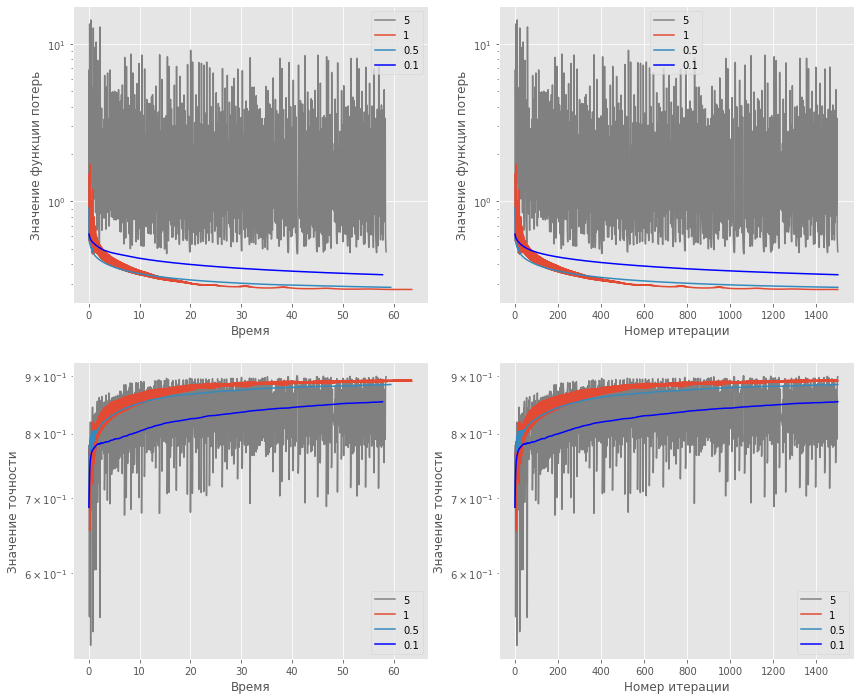

In [653]:
plt.style.use('ggplot')

f = plt.figure(figsize=(14, 12))
plt.subplot(221)
plt.plot(np.array(alphas_hist[5]['time']).cumsum(), alphas_hist[5]['func'][1:], label='5', c='grey')
plt.plot(np.array(alphas_hist[1]['time']).cumsum(), alphas_hist[1]['func'][1:], label='1')
plt.plot(np.array(alphas_hist[0.5]['time']).cumsum(), alphas_hist[0.5]['func'][1:], label='0.5')
plt.plot(np.array(alphas_hist[0.1]['time']).cumsum(), alphas_hist[0.1]['func'][1:], label='0.1', c='blue')
plt.yscale('log')
plt.ylabel('Значение функции потерь')
plt.xlabel('Время')
plt.legend()

plt.subplot(222)
plt.plot(alphas_hist[5]['func'][1:], label='5', c='grey')
plt.plot(alphas_hist[1]['func'][1:], label='1')
plt.plot(alphas_hist[0.5]['func'][1:], label='0.5')
plt.plot(alphas_hist[0.1]['func'][1:], label='0.1', c='blue')
plt.yscale('log')
plt.ylabel('Значение функции потерь')
plt.xlabel('Номер итерации')
plt.legend()

plt.subplot(223)
plt.plot(np.array(alphas_hist[5]['time']).cumsum(), alphas_hist[5]['accuracy'][1:], label='5', c='grey')
plt.plot(np.array(alphas_hist[1]['time']).cumsum(), alphas_hist[1]['accuracy'][1:], label='1')
plt.plot(np.array(alphas_hist[0.5]['time']).cumsum(), alphas_hist[0.5]['accuracy'][1:], label='0.5')
plt.plot(np.array(alphas_hist[0.1]['time']).cumsum(), alphas_hist[0.1]['accuracy'][1:], label='0.1', c='blue')
plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Время')
plt.legend()

plt.subplot(224)
plt.plot(alphas_hist[5]['accuracy'][1:], label='5', c='grey')
plt.plot(alphas_hist[1]['accuracy'][1:], label='1')
plt.plot(alphas_hist[0.5]['accuracy'][1:], label='0.5')
plt.plot(alphas_hist[0.1]['accuracy'][1:], label='0.1', c='blue')
plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Номер итерации')
plt.legend()

f.savefig("gd_alpha.pdf")

In [632]:
betas = [-0.5, 0, 1]
betas_hist = {}
for beta in betas:
    betas_hist[beta] = get_hist_gd(1, beta, None)

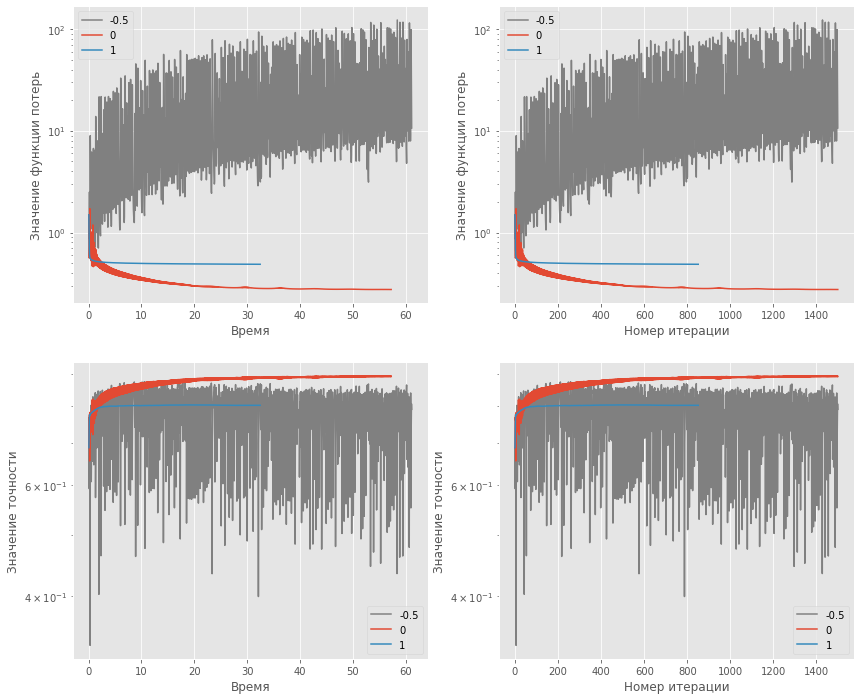

In [654]:
f = plt.figure(figsize=(14, 12))
plt.subplot(221)
plt.plot(np.array(betas_hist[-0.5]['time']).cumsum(), betas_hist[-0.5]['func'][1:], label='-0.5', c='grey')
plt.plot(np.array(betas_hist[0]['time']).cumsum(), betas_hist[0]['func'][1:], label='0')
plt.plot(np.array(betas_hist[1]['time']).cumsum(), betas_hist[1]['func'][1:], label='1')
plt.yscale('log')
plt.ylabel('Значение функции потерь')
plt.xlabel('Время')
plt.legend()

plt.subplot(222)
plt.plot(betas_hist[-0.5]['func'][1:], label='-0.5', c='grey')
plt.plot(betas_hist[0]['func'][1:], label='0')
plt.plot(betas_hist[1]['func'][1:], label='1')


plt.yscale('log')
plt.ylabel('Значение функции потерь')
plt.xlabel('Номер итерации')
plt.legend()

plt.subplot(223)
plt.plot(np.array(betas_hist[-0.5]['time']).cumsum(), betas_hist[-0.5]['accuracy'][1:], label='-0.5', c='grey')
plt.plot(np.array(betas_hist[0]['time']).cumsum(), betas_hist[0]['accuracy'][1:], label='0')
plt.plot(np.array(betas_hist[1]['time']).cumsum(), betas_hist[1]['accuracy'][1:], label='1')

plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Время')
plt.legend()

plt.subplot(224)
plt.plot(betas_hist[-0.5]['accuracy'][1:], label='-0.5', c='grey')
plt.plot(betas_hist[0]['accuracy'][1:], label='0')
plt.plot(betas_hist[1]['accuracy'][1:], label='1')

plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Номер итерации')
plt.legend()
f.savefig("gd_beta.pdf")


In [806]:
w0 = [np.zeros(train_csr.shape[1]), np.ones(train_csr.shape[1]), np.random.rand(train_csr.shape[1]), \
      np.random.normal(size=train_csr.shape[1])]
w0_hist = {}
for i in range(4):
    w0_hist[i] = get_hist_gd(1, 0, w0[i])

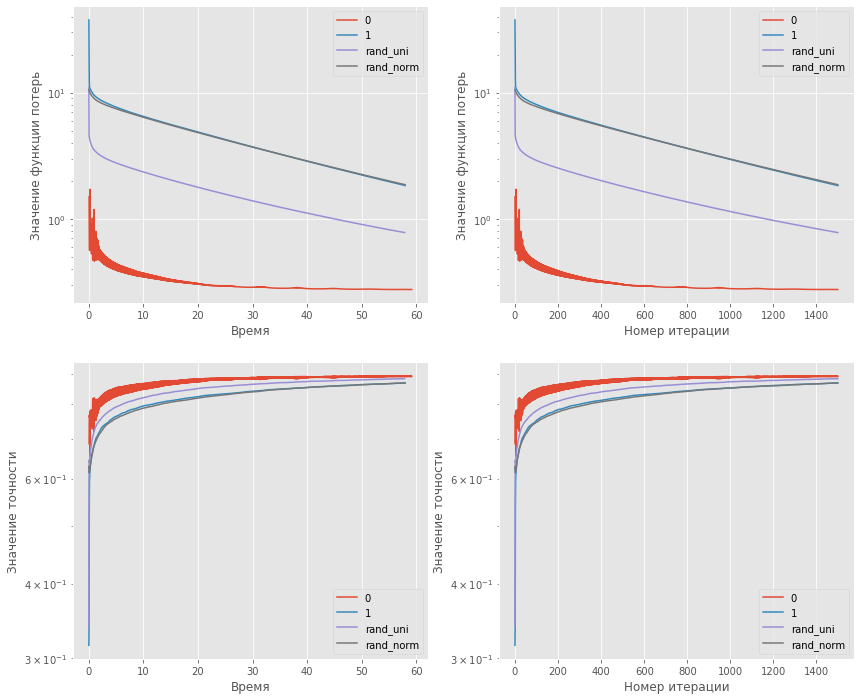

In [807]:
f = plt.figure(figsize=(14, 12))
vec = ['0', '1', 'rand_uni', 'rand_norm']
plt.subplot(221)
for i in range(4):
    plt.plot(np.array(w0_hist[i]['time']).cumsum(), w0_hist[i]['func'][1:], label=vec[i])
plt.yscale('log')
plt.ylabel('Значение функции потерь')
plt.xlabel('Время')
plt.legend()

plt.subplot(222)
for i in range(4):
    plt.plot(w0_hist[i]['func'][1:], label=vec[i])

plt.yscale('log')
plt.ylabel('Значение функции потерь')
plt.xlabel('Номер итерации')
plt.legend()

plt.subplot(223)
for i in range(4):
    plt.plot(np.array(w0_hist[i]['time']).cumsum(), w0_hist[i]['accuracy'][1:], label=vec[i])

plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Время')
plt.legend()

plt.subplot(224)
for i in range(4):
    plt.plot(w0_hist[i]['accuracy'][1:], label=vec[i])

plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Номер итерации')
plt.legend()
f.savefig("gd_w0.pdf")


In [813]:
def get_sgd_params(tol, it, l2):
    sgd = SGDClassifier('binary_logistic', step_alpha=1, step_beta=0, tolerance=tol, max_iter=it, l2_coef=l2,\
                        batch_size=1000)
    hist = sgd.fit(train_csr, y_train.values, trace=True, X_test=test_csr , \
                  y_test=y_test.values)
    return  np.equal(y_test.values, sgd.predict(test_csr).astype(int)).astype(int).mean() 
iters = [2000, 3500]
tols = [5e-7, 1e-7]
coefs = [3e-8, 5e-8]
sgd_params = {}
for tol in tols:
    for it in iters:
        for l2 in coefs:
                sgd_params[(tol, it, l2)] = get_sgd_params(tol, it, l2)

In [814]:
sgd_params

{(5e-07, 2000, 3e-08): 0.8969210174029452,
 (5e-07, 2000, 5e-08): 0.8968628135731331,
 (5e-07, 3500, 3e-08): 0.8969210174029452,
 (5e-07, 3500, 5e-08): 0.8968628135731331,
 (1e-07, 2000, 3e-08): 0.893254176124789,
 (1e-07, 2000, 5e-08): 0.9014027122984692,
 (1e-07, 3500, 3e-08): 0.893254176124789,
 (1e-07, 3500, 5e-08): 0.9014027122984692}

{(5e-07, 2000, 3e-08): 0.8969210174029452,
 (5e-07, 2000, 5e-08): 0.8968628135731331,
 (5e-07, 3500, 3e-08): 0.8969210174029452,
 (5e-07, 3500, 5e-08): 0.8968628135731331,
 (1e-07, 2000, 3e-08): 0.893254176124789,
 (1e-07, 2000, 5e-08): 0.9014027122984692,
 (1e-07, 3500, 3e-08): 0.893254176124789,
 (1e-07, 3500, 5e-08): 0.9014027122984692}

In [815]:
def get_hist_sgd(alpha, beta, w_0, batch):
    sgd = SGDClassifier('binary_logistic', step_alpha=alpha, step_beta=beta, tolerance=1e-7, 
                      max_iter=2000, l2_coef=5e-8, batch_size=batch)
    return sgd.fit(train_csr, y_train.values, trace=True, w_0=w_0, X_test=test_csr,
                  y_test=y_test.values)

In [816]:
alphas = [0.1, 0.5, 1, 5]
alphas_hist = {}
for alpha in alphas:
    alphas_hist[alpha] = get_hist_sgd(alpha, 0, None, 1000)

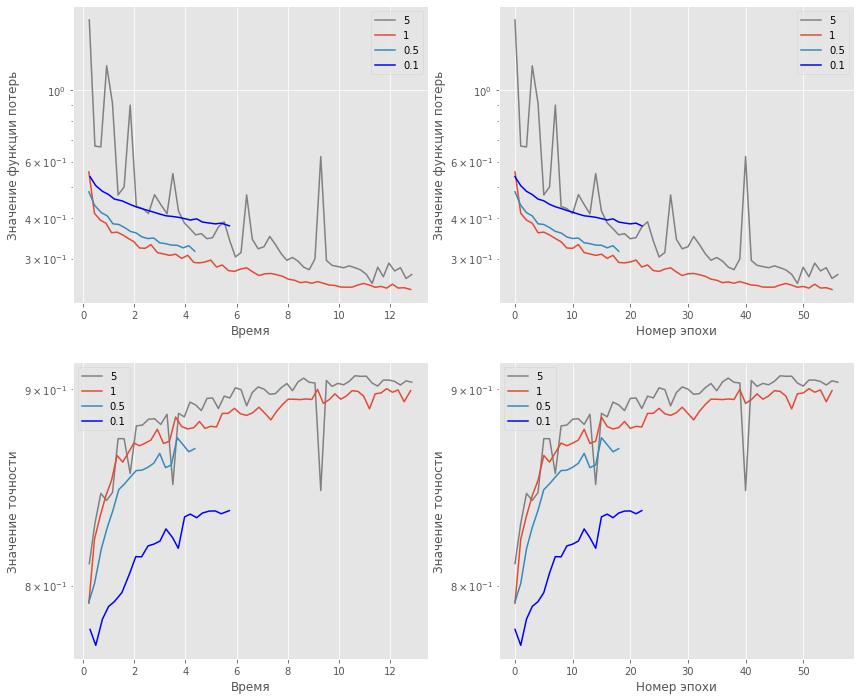

In [817]:
plt.style.use('ggplot')

f = plt.figure(figsize=(14, 12))
plt.subplot(221)
plt.plot(np.array(alphas_hist[5]['time']).cumsum(), alphas_hist[5]['func'][1:], label='5', c='grey')
plt.plot(np.array(alphas_hist[1]['time']).cumsum(), alphas_hist[1]['func'][1:], label='1')
plt.plot(np.array(alphas_hist[0.5]['time']).cumsum(), alphas_hist[0.5]['func'][1:], label='0.5')
plt.plot(np.array(alphas_hist[0.1]['time']).cumsum(), alphas_hist[0.1]['func'][1:], label='0.1', c='blue')
plt.yscale('log')
plt.ylabel('Значение функции потерь')
plt.xlabel('Время')
plt.legend()

plt.subplot(222)
plt.plot(alphas_hist[5]['func'][1:], label='5', c='grey')
plt.plot(alphas_hist[1]['func'][1:], label='1')
plt.plot(alphas_hist[0.5]['func'][1:], label='0.5')
plt.plot(alphas_hist[0.1]['func'][1:], label='0.1', c='blue')
plt.yscale('log')
plt.ylabel('Значение функции потерь')
plt.xlabel('Номер эпохи')
plt.legend()

plt.subplot(223)
plt.plot(np.array(alphas_hist[5]['time']).cumsum(), alphas_hist[5]['accuracy'][1:], label='5', c='grey')
plt.plot(np.array(alphas_hist[1]['time']).cumsum(), alphas_hist[1]['accuracy'][1:], label='1')
plt.plot(np.array(alphas_hist[0.5]['time']).cumsum(), alphas_hist[0.5]['accuracy'][1:], label='0.5')
plt.plot(np.array(alphas_hist[0.1]['time']).cumsum(), alphas_hist[0.1]['accuracy'][1:], label='0.1', c='blue')
plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Время')
plt.legend()

plt.subplot(224)
plt.plot(alphas_hist[5]['accuracy'][1:], label='5', c='grey')
plt.plot(alphas_hist[1]['accuracy'][1:], label='1')
plt.plot(alphas_hist[0.5]['accuracy'][1:], label='0.5')
plt.plot(alphas_hist[0.1]['accuracy'][1:], label='0.1', c='blue')
plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Номер эпохи')
plt.legend()
f.savefig("sgd_alpha.pdf")

In [818]:
betas = [-0.5, 0, 1]
betas_hist = {}
for beta in betas:
    betas_hist[beta] = get_hist_sgd(1, beta, None, 1000)

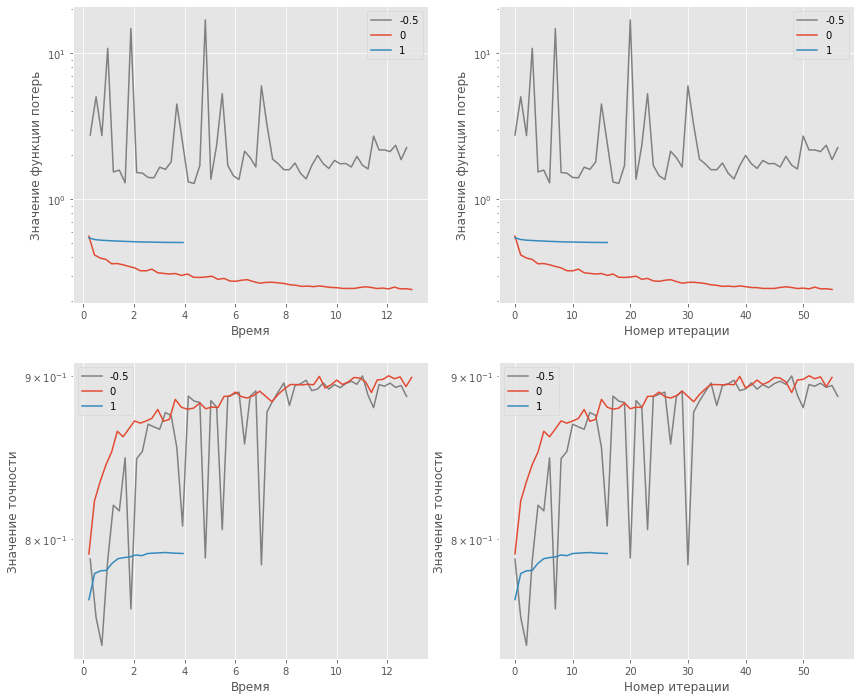

In [819]:
f = plt.figure(figsize=(14, 12))
plt.subplot(221)
plt.plot(np.array(betas_hist[-0.5]['time']).cumsum(), betas_hist[-0.5]['func'][1:], label='-0.5', c='grey')
plt.plot(np.array(betas_hist[0]['time']).cumsum(), betas_hist[0]['func'][1:], label='0')
plt.plot(np.array(betas_hist[1]['time']).cumsum(), betas_hist[1]['func'][1:], label='1')
plt.yscale('log')
plt.ylabel('Значение функции потерь')
plt.xlabel('Время')
plt.legend()

plt.subplot(222)
plt.plot(betas_hist[-0.5]['func'][1:], label='-0.5', c='grey')
plt.plot(betas_hist[0]['func'][1:], label='0')
plt.plot(betas_hist[1]['func'][1:], label='1')


plt.yscale('log')
plt.ylabel('Значение функции потерь')
plt.xlabel('Номер итерации')
plt.legend()

plt.subplot(223)
plt.plot(np.array(betas_hist[-0.5]['time']).cumsum(), betas_hist[-0.5]['accuracy'][1:], label='-0.5', c='grey')
plt.plot(np.array(betas_hist[0]['time']).cumsum(), betas_hist[0]['accuracy'][1:], label='0')
plt.plot(np.array(betas_hist[1]['time']).cumsum(), betas_hist[1]['accuracy'][1:], label='1')

plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Время')
plt.legend()

plt.subplot(224)
plt.plot(betas_hist[-0.5]['accuracy'][1:], label='-0.5', c='grey')
plt.plot(betas_hist[0]['accuracy'][1:], label='0')
plt.plot(betas_hist[1]['accuracy'][1:], label='1')

plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Номер итерации')
plt.legend()
f.savefig("sgd_beta.pdf")

In [820]:
w0 = [np.zeros(train_csr.shape[1]), np.ones(train_csr.shape[1]), np.random.rand(train_csr.shape[1]), \
      np.random.normal(size=train_csr.shape[1])]
w0_hist = {}
for i in range(4):
    w0_hist[i] = get_hist_sgd(1, 0, w0[i], 1000)

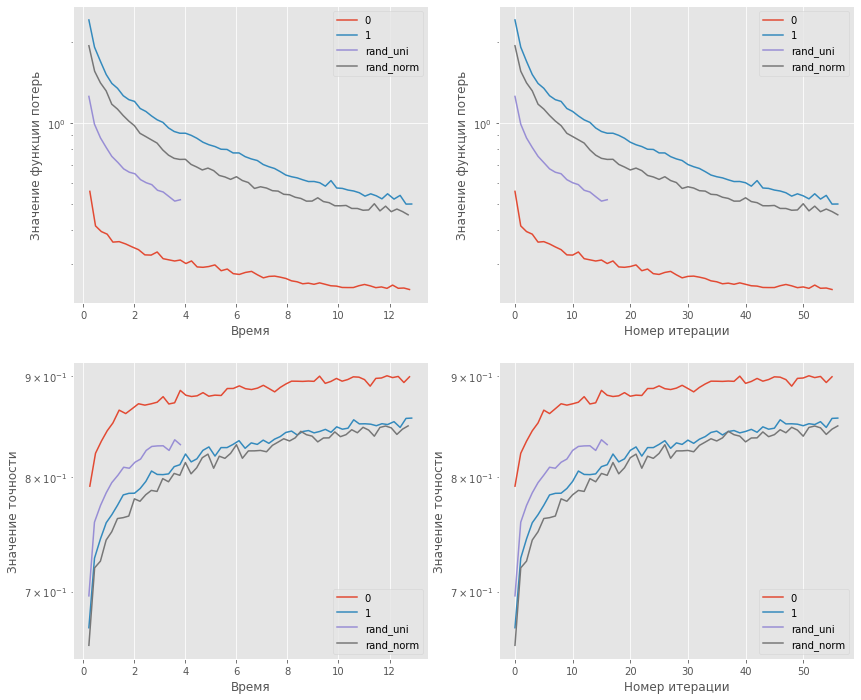

In [821]:
f = plt.figure(figsize=(14, 12))
vec = ['0', '1', 'rand_uni', 'rand_norm']
plt.subplot(221)
for i in range(4):
    plt.plot(np.array(w0_hist[i]['time']).cumsum(), w0_hist[i]['func'][1:], label=vec[i])
plt.yscale('log')
plt.ylabel('Значение функции потерь')
plt.xlabel('Время')
plt.legend()

plt.subplot(222)
for i in range(4):
    plt.plot(w0_hist[i]['func'][1:], label=vec[i])

plt.yscale('log')
plt.ylabel('Значение функции потерь')
plt.xlabel('Номер итерации')
plt.legend()

plt.subplot(223)
for i in range(4):
    plt.plot(np.array(w0_hist[i]['time']).cumsum(), w0_hist[i]['accuracy'][1:], label=vec[i])

plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Время')
plt.legend()

plt.subplot(224)
for i in range(4):
    plt.plot(w0_hist[i]['accuracy'][1:], label=vec[i])

plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Номер итерации')
plt.legend()
f.savefig("sgd_w0.pdf")

In [822]:
batches = [500, 1000, 1500, 2500]
batch_hist = {}
for batch in batches:
    batch_hist[batch] = get_hist_sgd(1, 0, None, batch)

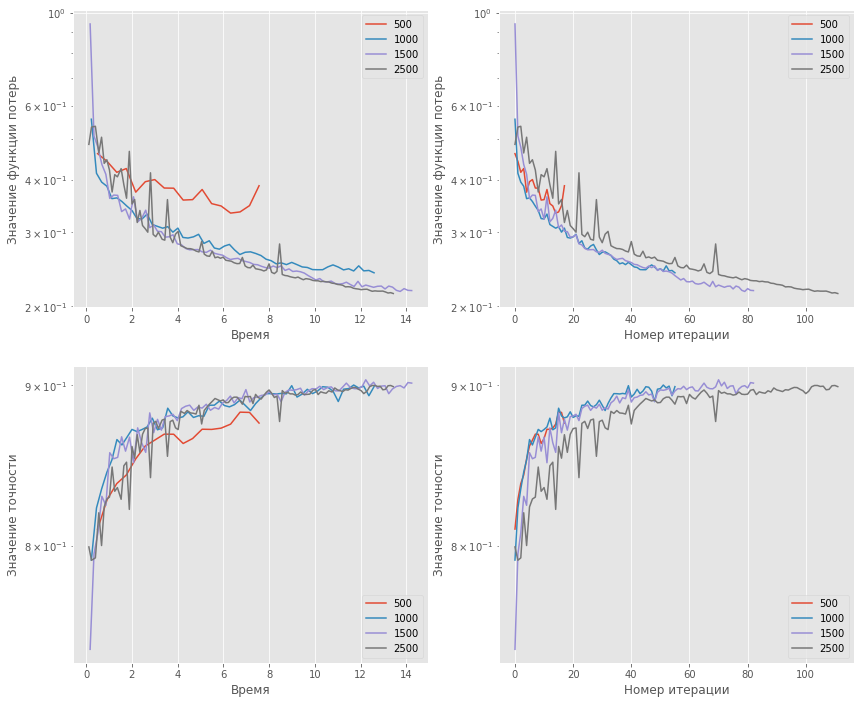

In [823]:
f = plt.figure(figsize=(14, 12))
plt.subplot(221)
for batch in batches:
    plt.plot(np.array(batch_hist[batch]['time']).cumsum(), batch_hist[batch]['func'][1:], label=str(batch))
plt.yscale('log')
plt.ylabel('Значение функции потерь')
plt.xlabel('Время')
plt.legend()

plt.subplot(222)
for batch in batches:
    plt.plot(batch_hist[batch]['func'][1:], label=str(batch))

plt.yscale('log')
plt.ylabel('Значение функции потерь')
plt.xlabel('Номер итерации')
plt.legend()

plt.subplot(223)
for batch in batches:
    plt.plot(np.array(batch_hist[batch]['time']).cumsum(), batch_hist[batch]['accuracy'][1:], label=str(batch))

plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Время')
plt.legend()

plt.subplot(224)
for batch in batches:
    plt.plot(batch_hist[batch]['accuracy'][1:], label=str(batch))

plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Номер итерации')
plt.legend()
f.savefig("sgd_batch.pdf")

In [837]:
gd = GDClassifier('binary_logistic', step_alpha=1, step_beta=0, tolerance=1e-7, max_iter=1500, l2_coef=5e-8)
hist_gd = gd.fit(train_csr, y_train.values, trace=True, X_test=test_csr, y_test=y_test.values)

In [838]:
sgd = SGDClassifier('binary_logistic', step_alpha=1, step_beta=0, tolerance=1e-7, \
                    max_iter=2000, l2_coef=5e-8, batch_size=1500)
hist_sgd = sgd.fit(train_csr, y_train.values, trace=True, X_test=test_csr, y_test=y_test.values)

In [845]:
print(hist_gd['accuracy'][-1])
hist_sgd['accuracy'][-1]

0.9007042663407252


0.9015773237879052

In [846]:
print(hist_gd['func'][-1])
hist_sgd['func'][-1]

0.21065005910469534


0.2181997744167247

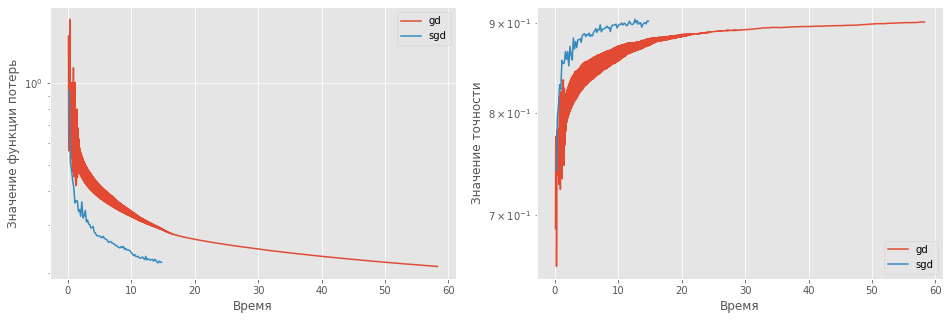

In [843]:
f = plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(np.array(hist_gd['time']).cumsum(), hist_gd['func'][1:], label='gd')
plt.plot(np.array(hist_sgd['time']).cumsum(), hist_sgd['func'][1:], label='sgd')
plt.yscale('log')
plt.ylabel('Значение функции потерь')
plt.xlabel('Время')
plt.legend()

plt.subplot(122)
plt.plot(np.array(hist_gd['time']).cumsum(), hist_gd['accuracy'][1:], label='gd')
plt.plot(np.array(hist_sgd['time']).cumsum(), hist_sgd['accuracy'][1:], label='sgd')

plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Время')
plt.legend()
f.savefig("gd_vs_sgd.pdf")

Предобработка: лемматизация и удаление стоп слов

In [847]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nastyabaklanova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [848]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nastyabaklanova/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [849]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nastyabaklanova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [850]:
lemmatizer = WordNetLemmatizer()

In [851]:
data = pd.read_csv('toxic_train.csv')
del data['Unnamed: 0']
data['answer'] = data['is_toxic'].replace(False, -1).astype(np.int8)
data['comment_text'] = data['comment_text'].str.lower()
data['comment_text'] = data['comment_text'].str.replace(r'[^a-zа-яё0-9]', ' ')

data['comment_text'] = data['comment_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) \
                                                                                for w in nltk.word_tokenize(x)]))
data['comment_text'] = data['comment_text'].str.split(' ')


In [852]:
data['comment_text'] = data['comment_text'].apply(lambda word_list: ' '.join([word for word in word_list if 
                                                              word not in stopwords.words('english')]))

In [853]:
train_data, test_data, y_train, y_test = sklearn.model_selection.train_test_split(data['comment_text'], 
                                                          data['answer'], test_size=0.33, random_state=42)

Реализация BOW

In [1192]:
1/len(train_data.values)

2.8669724770642203e-05

In [1199]:
min_freq = [0, 2.87e-5, 6e-5]
max_freq = [15e-3, 3e-3]
num_of_words_min = {}
hist_min_df = {}
num_of_words_max = {}
hist_max_df = {}

In [1200]:
for max_df in max_freq:
    bag_of_words = CountVectorizer(max_df=max_df)
    bag_of_words.fit(train_data.values)
    train_csr = bag_of_words.transform(train_data.values)
    test_csr = bag_of_words.transform(test_data.values)

    train_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((train_csr.shape[0], 1)), dtype = int), train_csr)))
    test_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((test_csr.shape[0], 1)), dtype = int), test_csr)))

    num_of_words_max[max_df] = train_csr.shape[1]
    sgd = SGDClassifier('binary_logistic', step_alpha=1, step_beta=0, tolerance=1e-7, \
                max_iter=2000, l2_coef=5e-8, batch_size=1500)
    hist_max_df[max_df] = sgd.fit(train_csr, y_train.values, trace=True, X_test=test_csr, y_test=y_test.values)

In [1201]:
for min_df in min_freq:
    bag_of_words = CountVectorizer(min_df=min_df)
    bag_of_words.fit(train_data.values)
    train_csr = bag_of_words.transform(train_data.values)
    test_csr = bag_of_words.transform(test_data.values)

    train_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((train_csr.shape[0], 1)), dtype = int), train_csr)))
    test_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((test_csr.shape[0], 1)), dtype = int), test_csr)))

    num_of_words_min[min_df] = train_csr.shape[1]
    sgd = SGDClassifier('binary_logistic', step_alpha=1, step_beta=0, tolerance=1e-7, \
                max_iter=2000, l2_coef=5e-8, batch_size=1500)
    hist_min_df[min_df] = sgd.fit(train_csr, y_train.values, trace=True, X_test=test_csr, y_test=y_test.values)

In [855]:
gd = GDClassifier('binary_logistic', step_alpha=1, step_beta=0, tolerance=1e-7, max_iter=1500, l2_coef=5e-8)
lem_hist_gd = gd.fit(train_csr, y_train.values, trace=True, X_test=test_csr, y_test=y_test.values)

In [856]:
sgd = SGDClassifier('binary_logistic', step_alpha=1, step_beta=0, tolerance=1e-7, \
                    max_iter=2000, l2_coef=5e-8, batch_size=1500)
lem_hist_sgd = sgd.fit(train_csr, y_train.values, trace=True, X_test=test_csr, y_test=y_test.values)

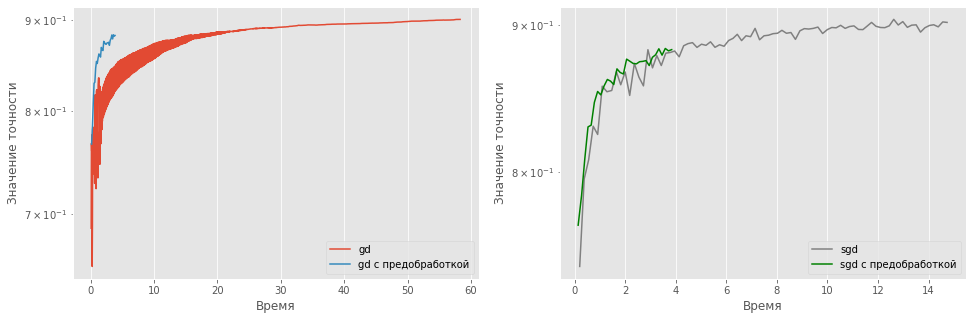

In [858]:
f = plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(np.array(hist_gd['time']).cumsum(), hist_gd['accuracy'][1:], label='gd')
plt.plot(np.array(lem_hist_sgd['time']).cumsum(), lem_hist_sgd['accuracy'][1:], label='gd с предобработкой')
plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Время')
plt.legend()

plt.subplot(122)
plt.plot(np.array(hist_sgd['time']).cumsum(), hist_sgd['accuracy'][1:], label='sgd', c='grey')
plt.plot(np.array(lem_hist_sgd['time']).cumsum(), lem_hist_sgd['accuracy'][1:], label='sgd с предобработкой', c='green')

plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Время')
plt.legend()
f.savefig("lem.pdf")

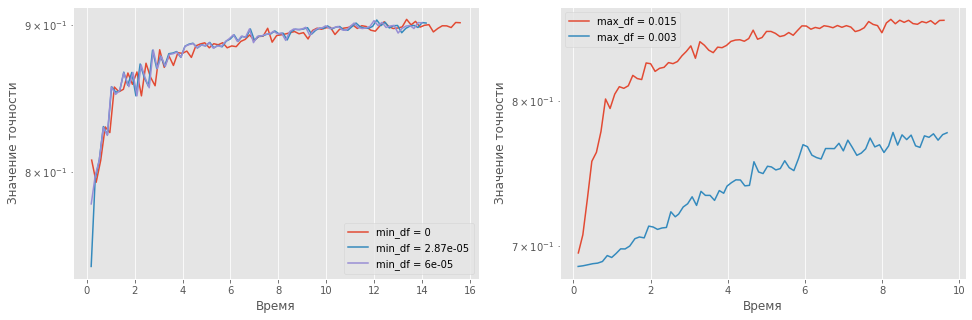

In [1202]:
f = plt.figure(figsize=(16, 5))
plt.subplot(121)
for min_df in min_freq:
    plt.plot(np.array(hist_min_df[min_df]['time']).cumsum(), hist_min_df[min_df]['accuracy'][1:], label='min_df = ' \
             + str(min_df))
plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Время')
plt.legend()

plt.subplot(122)

for max_df in max_freq:
    plt.plot(np.array(hist_max_df[max_df]['time']).cumsum(), hist_max_df[max_df]['accuracy'][1:], label='max_df = '\
             +str(max_df))
plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Время')
plt.legend()

f.savefig("bow_df.pdf")

In [1203]:
num_of_words_min

{0: 71074, 2.87e-05: 29826, 6e-05: 21088}

In [1204]:
num_of_words_max

{0.015: 70698, 0.003: 69433}

In [ ]:
sgd = SGDClassifier('binary_logistic', step_alpha=1, step_beta=0, tolerance=1e-7, \
                max_iter=2000, l2_coef=5e-8, batch_size=1500)
lem_hist_sgd = sgd.fit(train_csr, y_train.values, trace=True, X_test=test_csr, y_test=y_test.values)

реализация TfIdf

In [860]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [861]:
tfidf = TfidfVectorizer(min_df=3e-5)
tfidf.fit(train_data.values)
train_csr = tfidf.transform(train_data.values)
test_csr = tfidf.transform(test_data.values)

train_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((train_csr.shape[0], 1)), dtype = int), train_csr)))
test_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((test_csr.shape[0], 1)), dtype = int), test_csr)))


In [1205]:
min_freq = [0, 2.87e-5, 6e-5]
max_freq = [15e-3, 3e-3]
num_of_words_min = {}
hist_min_df = {}
num_of_words_max = {}
hist_max_df = {}

In [1206]:
for max_df in max_freq:
    tfidf = TfidfVectorizer(max_df=max_df)
    tfidf.fit(train_data.values)
    train_csr = tfidf.transform(train_data.values)
    test_csr = tfidf.transform(test_data.values)

    train_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((train_csr.shape[0], 1)), dtype = int), train_csr)))
    test_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((test_csr.shape[0], 1)), dtype = int), test_csr)))

    num_of_words_max[max_df] = train_csr.shape[1]
    sgd = SGDClassifier('binary_logistic', step_alpha=1, step_beta=0, tolerance=1e-7, \
                max_iter=2000, l2_coef=5e-8, batch_size=1500)
    hist_max_df[max_df] = sgd.fit(train_csr, y_train.values, trace=True, X_test=test_csr, y_test=y_test.values)

In [1207]:
for min_df in min_freq:
    tfidf = TfidfVectorizer(min_df=min_df)
    tfidf.fit(train_data.values)
    train_csr = tfidf.transform(train_data.values)
    test_csr = tfidf.transform(test_data.values)

    train_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((train_csr.shape[0], 1)), dtype = int), train_csr)))
    test_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((test_csr.shape[0], 1)), dtype = int), test_csr)))

    num_of_words_min[min_df] = train_csr.shape[1]
    sgd = SGDClassifier('binary_logistic', step_alpha=1, step_beta=0, tolerance=1e-7, \
                max_iter=2000, l2_coef=5e-8, batch_size=1500)
    hist_min_df[min_df] = sgd.fit(train_csr, y_train.values, trace=True, X_test=test_csr, y_test=y_test.values)

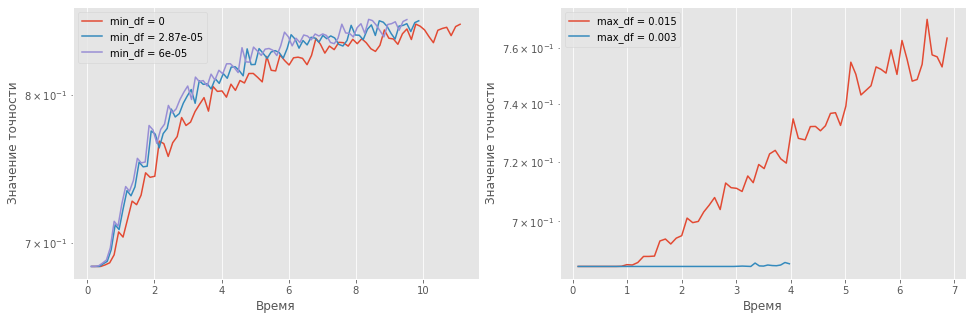

In [1208]:
f = plt.figure(figsize=(16, 5))
plt.subplot(121)
for min_df in min_freq:
    plt.plot(np.array(hist_min_df[min_df]['time']).cumsum(), hist_min_df[min_df]['accuracy'][1:], label='min_df = '+\
             str(min_df))
plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Время')
plt.legend()

plt.subplot(122)

for max_df in max_freq:
    plt.plot(np.array(hist_max_df[max_df]['time']).cumsum(), hist_max_df[max_df]['accuracy'][1:], label='max_df = '+\
             str(max_df))
plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Время')
plt.legend()

f.savefig("tfidf_df.pdf")

In [1209]:
num_of_words_min

{0: 71074, 2.87e-05: 29826, 6e-05: 21088}

In [1210]:
num_of_words_max

{0.015: 70698, 0.003: 69433}

In [1211]:
bag_of_words = CountVectorizer(min_df=2.87e-5)
bag_of_words.fit(train_data.values)
train_csr = bag_of_words.transform(train_data.values)
test_csr = bag_of_words.transform(test_data.values)

train_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((train_csr.shape[0], 1)), dtype = int), train_csr)))
test_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((test_csr.shape[0], 1)), dtype = int), test_csr)))

sgd = SGDClassifier('binary_logistic', step_alpha=1, step_beta=0, tolerance=1e-7, \
            max_iter=2000, l2_coef=5e-8, batch_size=1500)
hist_bow = sgd.fit(train_csr, y_train.values, trace=True, X_test=test_csr, y_test=y_test.values)

In [1212]:
tfidf = TfidfVectorizer(min_df=2.87e-5)
tfidf.fit(train_data.values)
train_csr = tfidf.transform(train_data.values)
test_csr = tfidf.transform(test_data.values)

train_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((train_csr.shape[0], 1)), dtype = int), train_csr)))
test_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((test_csr.shape[0], 1)), dtype = int), test_csr)))

sgd = SGDClassifier('binary_logistic', step_alpha=1, step_beta=0, tolerance=1e-7, \
            max_iter=2000, l2_coef=5e-8, batch_size=1500)
hist_tfidf = sgd.fit(train_csr, y_train.values, trace=True, X_test=test_csr, y_test=y_test.values)

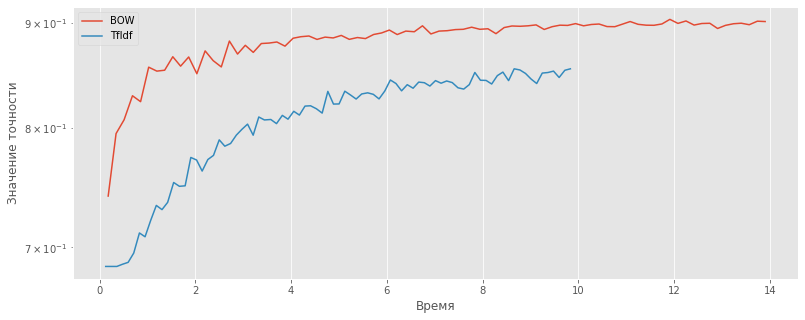

In [1213]:
f = plt.figure(figsize=(13, 5))

plt.plot(np.array(hist_bow['time']).cumsum(), hist_bow['accuracy'][1:], label='BOW')
plt.plot(np.array(hist_tfidf['time']).cumsum(), hist_tfidf['accuracy'][1:], label='TfIdf')
plt.yscale('log')
plt.ylabel('Значение точности')
plt.xlabel('Время')
plt.legend()

f.savefig("bow_vs_tfidf.pdf")

а теперь лучшее к тесту


In [1214]:
1/data.shape[0]

1.9208236491807687e-05

In [1215]:
bag_of_words = CountVectorizer(min_df=1.93e-5)
bag_of_words.fit(data['comment_text'].values)
train_csr = bag_of_words.transform(data['comment_text'].values)
test_csr = bag_of_words.transform(test['comment_text'].values)
y_train = data['answer'].values
y_test = test['answer'].values
train_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((train_csr.shape[0], 1)), dtype = int), train_csr)))
test_csr = csr_matrix(sparse.hstack((csr_matrix(np.ones((test_csr.shape[0], 1)), dtype = int), test_csr)))

In [1216]:
sgd = SGDClassifier('binary_logistic', step_alpha=1, step_beta=0, tolerance=1e-8, \
            max_iter=2000, l2_coef=5e-8, batch_size=2000)
history = sgd.fit(train_csr, y_train, trace=True, X_test=test_csr, y_test=y_test)

In [1217]:
np.equal(sgd.predict(test_csr), y_test).astype(int).mean()

0.8828593538402012

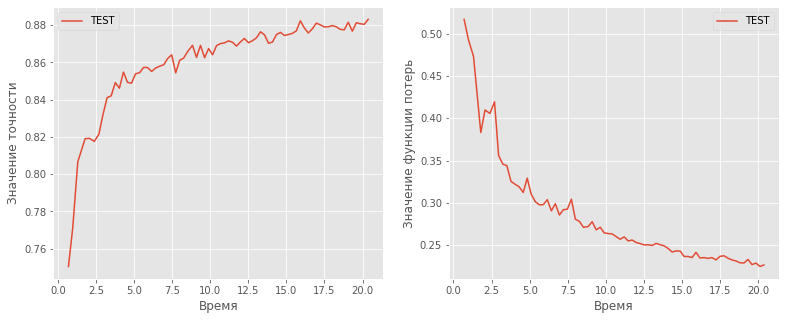

In [1218]:
f = plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.plot(np.array(history['time']).cumsum(), history['accuracy'][1:], label='TEST')


plt.ylabel('Значение точности')
plt.xlabel('Время')
plt.legend()

plt.subplot(122)
plt.plot(np.array(history['time']).cumsum(), history['func'][1:], label='TEST')

plt.ylabel('Значение функции потерь')
plt.xlabel('Время')
plt.legend()

f.savefig("test.pdf")

In [1219]:
np.arange(test_csr.shape[0])[np.equal(sgd.predict(test_csr), y_test).astype(int) == 0]

array([    1,     2,    12, ..., 20635, 20652, 20674])

In [1220]:
errors = test.loc[np.arange(test_csr.shape[0])[np.equal(sgd.predict(test_csr), \
                                                        y_test).astype(int) == 0]].copy(deep=True)

In [1221]:
errors['predict'] = sgd.predict(test_csr)[np.equal(sgd.predict(test_csr), y_test).astype(int) == 0].astype(int)

In [1227]:
errors[errors['answer'] == 1].sample(5)

,comment_text,is_toxic,answer,predict
16823,stephen colbert likewise offered donald trump ...,True,1,-1
18872,nigga got pwnt blame xenu,True,1,-1
3753,jessica watson i d give her a f t d1ck up the ...,True,1,-1
16672,what a silly person with note to self to revok...,True,1,-1
18101,so just because a woman cuts her boobs off and...,True,1,-1


In [1223]:
test['comment_text'][14972]

':: and what a useless thought it is'